## Práctica LSTM-GloVe

#### Librerías

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time

from torchtext import datasets
from torchtext.data import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

#### Variables del entrenamiento

In [2]:
EPOCHS = 10 
LEARNING_RATE = 5
GLOVE_DIM = 300

#### Uso de la GPU

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Carga de los datos

In [4]:
train_iter, test_iter = datasets.AG_NEWS(split=('train', 'test'))

In [5]:
train_ds = to_map_style_dataset(train_iter)
test_ds = to_map_style_dataset(test_iter)

In [6]:
train = np.array(train_ds)
test = np.array(test_ds)

#### Creación del vocabulario

Este tokenizer dividirá el texto en palabras (tokens) utilizando reglas específicas para el inglés básico.

In [7]:
tokenizer = get_tokenizer("basic_english")

Este código tokeniza los textos en train_iter utilizando la función tokenizer y construye un vocabulario a partir de los tokens resultantes. El vocabulario incluirá todas las palabras únicas presentes en los datos de entrenamiento, junto con los tokens especiales `<pad>` y `<unk>`.

In [8]:
vocab = build_vocab_from_iterator(map(lambda x: tokenizer(x[1]), train_iter), specials=['<pad>','<unk>'])
vocab.set_default_index(vocab["<unk>"])

#### Creación de los dataloaders

* `text_pipeline`: Esta función convierte un texto en una secuencia de números enteros donde cada número entero representa una palabra o un token en el vocabulario.
* `label_pipeline`: Esta función toma una etiqueta `x` (presumiblemente una etiqueta de clase) y la convierte en un número entero restando 1 al valor original. Esto puede ser útil en tareas de clasificación en las que las etiquetas comienzan desde 1 en lugar de 0.

In [9]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

La función `collate_batch` toma una lista de muestras, donde cada muestra consta de una etiqueta y un texto. 

1. Procesa cada texto en el lote utilizando la función text_pipeline. Esto implica tokenizar el texto y convertirlo en una secuencia de números enteros utilizando un vocabulario.
2. Procesa cada etiqueta en el lote utilizando la función label_pipeline, que la convierte en un número entero.

In [10]:
def collate_batch(batch):
    label_list, text_list = [], []
    for sample in batch:
        label, text = sample
        text_list.append(torch.tensor(text_pipeline(text), dtype=torch.long))
        label_list.append(label_pipeline(label))
    return torch.tensor(label_list, dtype=torch.long), torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab["<pad>"])

In [11]:
train_dataloader = DataLoader(
    train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

#### Modelo sin Glove

En el método __init__:
* `vocab_size`: El tamaño del vocabulario, es decir, la cantidad de palabras únicas en los datos de entrada.
* `embed_dim`: La dimensión de los vectores de incrustación (embedding) que se utilizarán para representar las palabras.
* `hidden_dim`: La dimensión de los estados ocultos de la capa LSTM.

En el método `forward`
1.  Los datos de entrada (secuencias de texto) se pasan a través de la capa de incrustación para obtener representaciones vectoriales de palabras.
2. Los vectores de incrustación se pasan a través de la capa LSTM para obtener estados ocultos. La variable `lstm_out` contiene la secuencia de estados ocultos a lo largo del tiempo. El segundo valor, `_`, representa los estados de celda de la LSTM, que no se utilizan en este caso.
3. Se toma el último estado oculto de la secuencia LSTM, ya que generalmente se considera la representación más relevante para la tarea de clasificación.
4. El último estado oculto se pasa a través de la capa lineal para obtener las puntuaciones de clase. 

In [12]:
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text) 
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [13]:
model_without_glove = LSTMTextClassificationModel(len(vocab), 32, 64, 4).to(device)

#### Definición de hiperparámetros

In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer_without_glove = torch.optim.SGD(model_without_glove.parameters(), lr=LEARNING_RATE)
scheduler_without_glove = torch.optim.lr_scheduler.StepLR(optimizer_without_glove, 1.0, gamma=0.1)

#### Entrenamiento del modelo sin glove

* `train()`:  Este método entrena el modelo durante el número de épocas especificado. Durante cada época, se ejecuta el entrenamiento en el dataloader de entrenamiento, y luego se llama a `evaluate` para evaluar el modelo en el dataloader de prueba. Además, registra las métricas de precisión y pérdida en cada época y las imprime. Devuelve las métricas máximas, la precisión final y la pérdida final.
* `train_epoch`: Este método entrena el modelo durante una sola época. Divide el entrenamiento en lotes y actualiza los pesos del modelo después de cada lote. Calcula y registra la precisión y pérdida en cada lote y actualiza las métricas totales de la época.
* `evaluate`: Este método evalúa el modelo en el dataloader de prueba sin realizar ningún ajuste en los pesos. Calcula la precisión en el conjunto de prueba y la devuelve.
* `plot_metrics()`: Este método traza las métricas (precisión y pérdida) a lo largo de las épocas.
* `update_metrics()`: Actualiza las métricas de precisión y pérdida, y registra el progreso del entrenamiento en cada época. 
* `print_epoch_summary`:  Este método imprime un resumen al final de cada época con la precisión máxima en entrenamiento y la precisión en prueba.

In [ ]:
class TextClassificationTrainer:
    def __init__(self, model, optimizer, criterion, train_dataloader, test_dataloader, EPOCHS):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.EPOCHS = EPOCHS
        self.epoch_accuracies = []
        self.epoch_losses = []

    def train(self):
        for epoch in range(1, self.EPOCHS + 1):
            self.model.train()
            epoch_start_time = time.time()
            max_acc = self.train_epoch(epoch)
            accu_val = self.evaluate()
            self.epoch_accuracies.append(accu_val)
            self.epoch_losses.append(self.epoch_loss)
            self.print_epoch_summary(epoch, epoch_start_time, max_acc, accu_val)

    def train_epoch(self, epoch):
        total_acc, total_count, max_acc = 0, 0, 0
        log_interval = 500
        start_time = time.time()

        for idx, (label, text) in enumerate(self.train_dataloader):
            label = label.to(device)
            text = text.to(device)
            self.optimizer.zero_grad()
            predicted_label = self.model(text)
            loss = self.criterion(predicted_label, label)
            self.backward_and_optimize(loss)
            total_acc, total_count, max_acc, start_time = self.update_metrics(total_acc, total_count, max_acc, start_time, idx, log_interval, predicted_label, label)

        self.epoch_loss = loss.item()
        return max_acc

    def backward_and_optimize(self, loss):
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
        self.optimizer.step()

    def update_metrics(self, total_acc, total_count, max_acc, start_time, idx, log_interval, predicted_label, label):
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time

            if max_acc < total_acc / total_count:
                max_acc = total_acc / total_count

            total_acc, total_count = 0, 0
            start_time = time.time()

        return total_acc, total_count, max_acc, start_time


    def evaluate(self):
        self.model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad():
            for idx, (label, text) in enumerate(self.test_dataloader):
                label = label.to(device)
                text = text.to(device)
                predicted_label = self.model(text)
                loss = self.criterion(predicted_label, label)
                total_acc += (predicted_label.argmax(1) == label).sum().item()
                total_count += label.size(0)
        
        return total_acc / total_count

    def print_epoch_summary(self, epoch, epoch_start_time, max_acc, accu_val):
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "train accuracy {:8.3f} | valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, max_acc, accu_val
            )
        )
        print("-" * 59)

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_accuracies, label='Accuracy')
        plt.title ('Accuracy over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_losses, label='Loss', color='red')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [16]:
trainer = TextClassificationTrainer(model_without_glove, optimizer_without_glove, criterion, train_dataloader, test_dataloader, EPOCHS)
max_acc, final_accuracy, final_loss = trainer.train()

-----------------------------------------------------------
| end of epoch   1 | time: 22.90s | train accuracy    0.253 | valid accuracy    0.253 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 21.94s | train accuracy    0.261 | valid accuracy    0.252 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 20.47s | train accuracy    0.254 | valid accuracy    0.253 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 22.01s | train accuracy    0.458 | valid accuracy    0.470 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 23.23s | train accuracy    0.647 | valid accuracy    0.659 
-------------------------

#### Gráficas del entrenamiento

Si graficamos las métricas de *accuracy* y *loss* por cada época (1500 batches), nos daremos cuenta que el modelo parece converger, aunque al ser tan pocas épocas no podemos comprobar si realmente la pérdida consigue reducirse. 

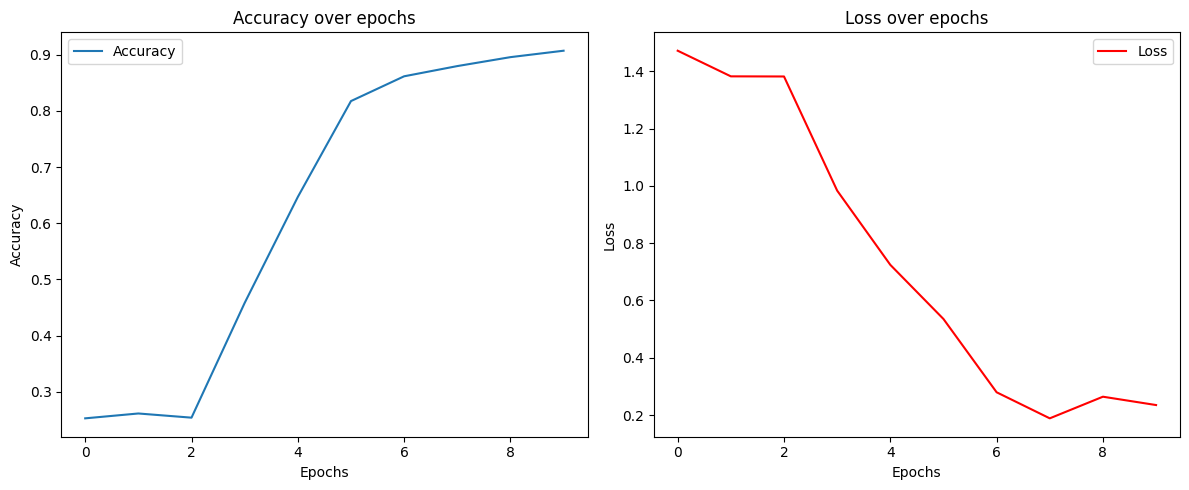

In [17]:
trainer.plot_metrics()

#### Evaluación del modelo sin Glove

* `evaluate()`: Este método realiza la evaluación del modelo utilizando un dataloader y el modelo especificado. Realiza la inferencia en el modelo en modo de evaluación y calcula métricas. Luego, devuelve un diccionario que contiene métricas.
* `get_y_true_and_y_pred()`: Un método que devuelve las listas y_true e y_pred que contienen las etiquetas verdaderas y predichas respectivamente después de la evaluación.
* `_get_classification_report()`: Un método interno que utiliza la función classification_report de `scikit-learn` para calcular un informe detallado de clasificación.
* `_update_metrics()`: Un método interno que calcula el promedio de una lista de valores.
* `_prepare_data()`: Un método interno que mueve los datos de texto y etiquetas al dispositivo (por ejemplo, GPU).

In [18]:
class Evaluate:
    def __init__(self, criterion):
        self.criterion = criterion
        self.y_true = []
        self.y_pred = []

    def evaluate(self, dataloader, model):
        precision, recall, score, accuracy = [], [], [], []
        model.eval()

        with torch.no_grad():
            for label, text in dataloader:
                text, label = self._prepare_data(text, label)
                predicted_label = model(text)
                report = self._get_classification_report(predicted_label.cpu(), label.cpu())  # Copia a la CPU
                self._update_metrics(report, label, predicted_label, precision, recall, score, accuracy)

                label_cpu = label.cpu().numpy()
                predicted_label_cpu = torch.argmax(predicted_label, dim=1).cpu().numpy()
                self.y_true.extend(label_cpu)
                self.y_pred.extend(predicted_label_cpu)

        return {
            "precision": self._calculate_average(precision),
            "recall": self._calculate_average(recall),
            "f1-score": self._calculate_average(score),
            "accuracy": self._calculate_average(accuracy)
        }

    def get_y_true_and_y_pred(self):
        return self.y_true, self.y_pred

    def _get_classification_report(self, predicted_label, label):
        return classification_report(torch.argmax(predicted_label, dim=1), label, output_dict=True)

    def _update_metrics(self, report, label, predicted_label, precision, recall, score, accuracy):
        precision.append(report['weighted avg']['precision'])
        recall.append(report['weighted avg']['recall'])
        score.append(report['weighted avg']['f1-score'])
        
        label_cpu = label.cpu().numpy()
        predicted_label_cpu = torch.argmax(predicted_label, dim=1).cpu().numpy()
        
        accuracy.append(accuracy_score(label_cpu, predicted_label_cpu))


    def _calculate_average(self, values):
        return sum(values) / len(values)

    def _prepare_data(self, text, label):
        text = text.to(device)
        label = label.to(device)
        return text, label

In [19]:
evaluator = Evaluate(criterion)
evaluation_metrics_no_glove = evaluator.evaluate(test_dataloader, model_without_glove)
y_true_no_globe, y_pred_no_globe = evaluator.get_y_true_and_y_pred()

In [20]:
evaluation_metrics_no_glove

{'precision': 0.8784336144494729,
 'recall': 0.8711484593837535,
 'f1-score': 0.8710885686361844,
 'accuracy': 0.8711484593837535}

#### Carga del modelo de embedding Glove

In [21]:
glove = GloVe(name="6B", dim=GLOVE_DIM)

* `text_pipeline`: En este caso, se toma una cadena de texto `x` como entrada. Se divide el texto en tokens (palabras o subcadenas) para que se pueda procesar por separado. Luego, se obtiene el vector GloVe pre-entrenado correspondiente a cada token y lo convierte en una lista de Python. Esto convierte el texto en una lista de vectores de palabras, uno para cada token.

In [22]:
text_pipeline = lambda x: [glove.get_vecs_by_tokens(token).tolist() for token in tokenizer(x)]
label_pipeline = lambda x: int(x) - 1

In [23]:
def collate_batch(batch):
    label_list, text_list = [], []
    for sample in batch:
        label, text = sample
        text_list.append(torch.tensor(text_pipeline(text)))
        label_list.append(label_pipeline(label))
    return torch.tensor(label_list, dtype=torch.long), torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0.)

In [24]:
train_dataloader = DataLoader(
    train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

#### Modelo LSMT con Glove

In [25]:
class GloVeTextClassificationModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_class):
        super(GloVeTextClassificationModel, self).__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, embedding):
        lstm_out, _ = self.lstm(embedding)  
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [26]:
model_with_glove = GloVeTextClassificationModel(GLOVE_DIM, 64, 4).to(device)

#### Definición de hiperparámetros

In [27]:
optimizer_with_glove = torch.optim.SGD(model_with_glove.parameters(), lr=LEARNING_RATE)
scheduler_with_glove = torch.optim.lr_scheduler.StepLR(optimizer_with_glove, 1.0, gamma=0.1)

#### Entrenamiento del modelo con Glove

In [29]:
trainer = TextClassificationTrainer(model_with_glove, optimizer_with_glove, criterion, train_dataloader, test_dataloader, EPOCHS)
max_acc, final_accuracy, final_loss = trainer.train()

-----------------------------------------------------------
| end of epoch   1 | time: 466.92s | train accuracy    0.657 | valid accuracy    0.680 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 470.34s | train accuracy    0.900 | valid accuracy    0.895 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 455.97s | train accuracy    0.916 | valid accuracy    0.906 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 434.23s | train accuracy    0.924 | valid accuracy    0.906 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 431.35s | train accuracy    0.930 | valid accuracy    0.906 
--------------------

#### Gráficas del entrenamiento

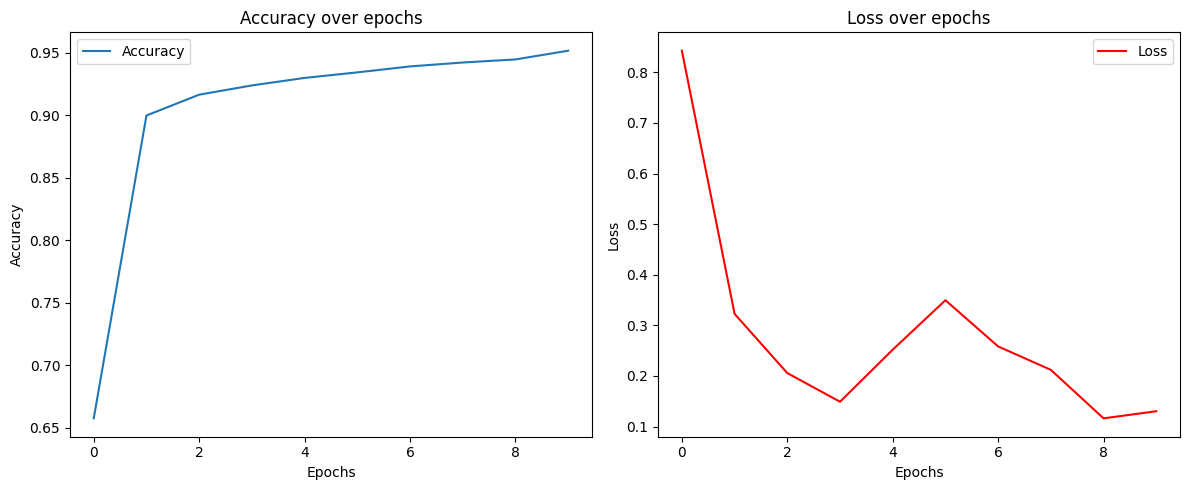

In [30]:
trainer.plot_metrics()

#### Evaluación del modelo con Glove

In [35]:
evaluator = Evaluate(criterion)
evaluation_metrics_glove = evaluator.evaluate(test_dataloader, model_with_glove)
y_true_globe, y_pred_globe = evaluator.get_y_true_and_y_pred()

In [36]:
evaluation_metrics_glove

{'precision': 0.9223474414342562,
 'recall': 0.9170605742296918,
 'f1-score': 0.9171032812442614,
 'accuracy': 0.9170605742296918}

#### Comparación de métricas por modelo

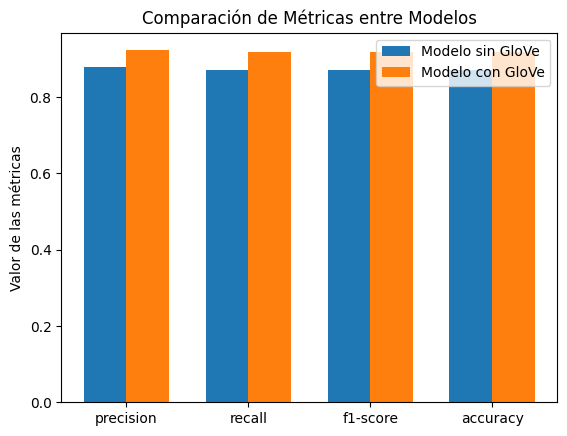

In [37]:
metric_names = list(evaluation_metrics_glove.keys())

values_model1 = [evaluation_metrics_no_glove[metric] for metric in metric_names]
values_model2 = [evaluation_metrics_glove[metric] for metric in metric_names]

x = range(len(metric_names))

width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, values_model1, width, label='Modelo sin GloVe')
rects2 = ax.bar([i + width for i in x], values_model2, width, label='Modelo con GloVe')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylabel('Valor de las métricas')
ax.set_title('Comparación de Métricas entre Modelos')
plt.show()

#### Comparación de matrices de confusión**

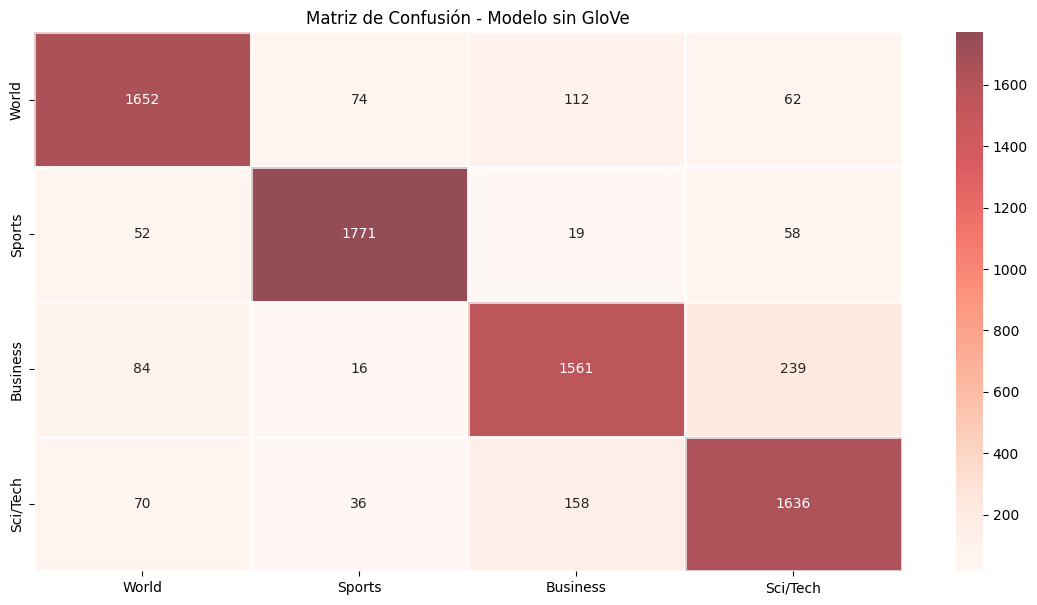

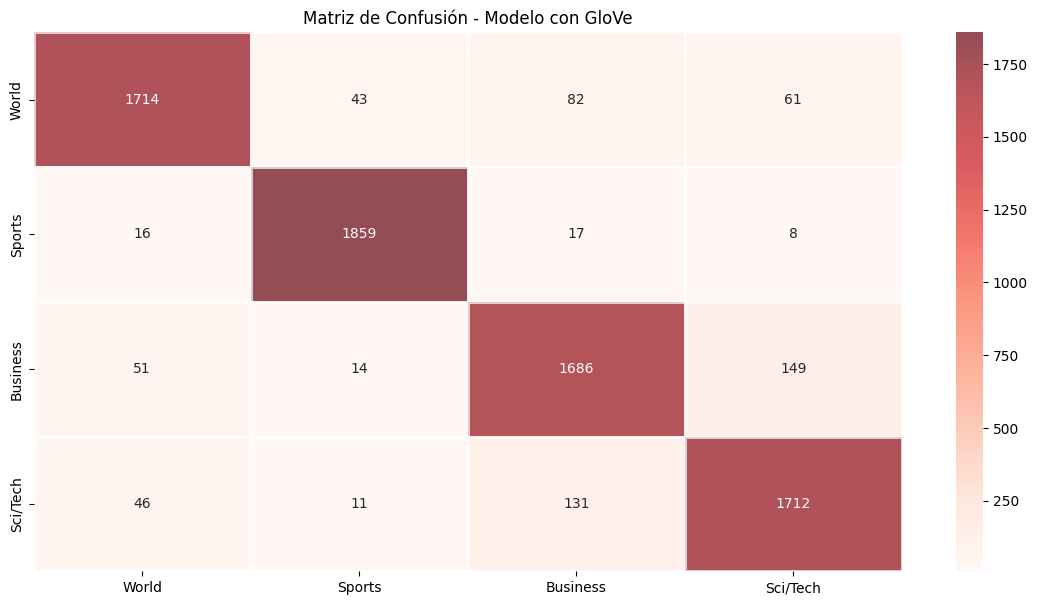

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_true_no_globe, y_pred_no_globe), ax=ax, xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], annot=True, fmt='g', alpha=0.7, linewidths=2,
            cmap=plt.cm.Reds)
ax.set_title('Matriz de Confusión - Modelo sin GloVe')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_true_globe, y_pred_globe), ax=ax, xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], annot=True, fmt='g', alpha=0.7, linewidths=2,
            cmap=plt.cm.Reds)
ax.set_title('Matriz de Confusión - Modelo con GloVe')
plt.show()